### 预训练网络
###### 一个保存好的网络，之前已在大型数据集（通常是大规模图像分类任务）上训练好。如果这个原始数据集足够大且足够通用，那么预训练网络学到的特征的空间层次结构可以有效的作为视觉世界的通用模型，因此这些特征可用于各种不同的计算机数据问题，即使这些新问题涉及的类别和原始任务完全不同。

### 5.3.1 特征提取

In [1]:
# 将VGG16卷积实例化
from keras.applications import VGG16

In [2]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))
# weights指定模型初始化的权重检查点
# include_top制定模型最后是否包含密集连接分类器。默认情况下，这个密集连接分类器对应于ImageNet的1000个类别。
# 因为我们打算使用自己的密集连接分类器（只有两个类别：cat dog），所以不需要包含它
# input_shape是输入到网络中的图像张量的形状

58892288/58889256 [==============================] - 966s 16us/step


In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### 1、不使用数据增强的快速特征提取

In [4]:
# 使用预训练的卷积基提取特征
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [8]:
base_dir='F:\kaggleDATA\dogs-vs-cats(new)'
train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir,'validation')
test_dir=os.path.join(base_dir,'test')

datagen=ImageDataGenerator(rescale=1/.255)
batch_size=20

def extract_features(directory,sample_count):
    features=np.zeros(shape=(sample_count,4,4,512))
    labels=np.zeros(shape=(sample_count))
    generator=datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch,labels_batch in generator:
        features_batch=conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size >= sample_count:
            break
    return features,labels

train_features,train_labels = extract_features(train_dir,2000)
validation_features,validation_labels = extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# 将提取的特征形状（samples,4,4,512）展平为（samples，8192）
train_features=np.reshape(train_features,(2000,4*4*512))
validation_features=np.reshape(validation_features,(1000,4*4*512))
test_features=np.reshape(test_features,(1000,4*4*512))

In [11]:
# 定义并训练密集连接分类器
from keras import models
from keras import layers
from keras import optimizers

model=models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
history=model.fit(train_features,train_labels,epochs=30,batch_size=20,validation_data=(validation_features,validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 8s 4ms/step - loss: 5.6601 - acc: 0.6250 - val_loss: 2.9131 - val_acc: 0.7850
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/step - loss: 3.9130 - acc: 0.7375 - val_loss: 1.9669 - val_acc: 0.8570
Epoch 3/30
2000/2000 [==============================] - 6s 3ms/step - loss: 3.0517 - acc: 0.7915 - val_loss: 1.6477 - val_acc: 0.8840
Epoch 4/30
2000/2000 [==============================] - 6s 3ms/step - loss: 2.7114 - acc: 0.8120 - val_loss: 1.4222 - val_acc: 0.9000
Epoch 5/30
2000/2000 [==============================] - 6s 3ms/step - loss: 2.1009 - acc: 0.8590 - val_loss: 1.2038 - val_acc: 0.9080
Epoch 6/30
2000/2000 [==============================] - 6s 3ms/step - loss: 2.0265 - acc: 0.8625 - val_loss: 1.2158 - val_acc: 0.9130
Epoch 7/30
2000/2000 [==============================] - 6s 3ms/step - loss: 1.8536 - acc: 0.8715 - val_loss: 1.1460 - val_acc: 0.9230
Epoch 8/30
200

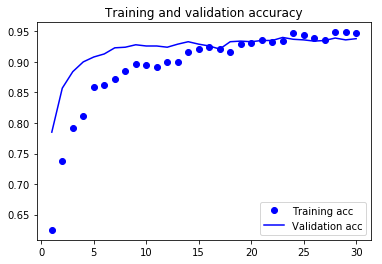

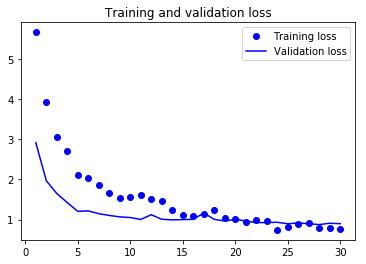

In [13]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 2、使用数据增强的特征提取

In [14]:
# 在卷积基上添加一个密集连接分类器

from keras import models
from keras import layers

model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


##### VGG16的卷积基有14714688个参数，非常多，在其上添加的分类器有200万个参数
##### 因此在编译和训练模型之前，一定要‘冻结’卷积基。
##### 冻结一个或多个层是指在训练过程中保持其权重不变。如果不那么做，那么卷积基之前学到的表示将会在训练过程中被修改。

In [16]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [17]:
# 冻结的方法
conv_base.trainable = False

In [18]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [ ]:
# 由于此段代码运行时间过长，所以本段代码不进行运行
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

In [20]:
model.save('cats_and_dogs_small_3.h5')

### 5.3.2 微调模型-与特征提取互为补充

对于特征提取的冻结的模型基，微调是指将其顶部的几层“解冻”，并将这解冻的几层和新增加的部分联合训练。

#### 微调网络的步骤

##### （1）在已训练好的基网络上添加自定义网络

##### （2）冻结基网络

##### （3）训练所添加的部分

##### （4）解冻及网络的一些层

##### （5）联合训练解冻的这些层和添加的部分

In [21]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

我们将微调最后三个卷积层，也就是直到block4_pool的所有层都应该被冻结，而block5_conv1\2\3三个层应该是可训练的。

In [22]:
# 冻结直到某一层的所有层
conv_base.trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [ ]:
# 模型微调
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-5),metrics=['acc'])

history=model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

## 小结：

### 1、卷积神经网络是用于计算机视觉任务的最佳机器学习模型。即使在非常小的数据集上也可以从头训练一个卷积神经网络，而且得到的结果还不错。

### 2、在小型数据集上的主要问题是过拟合。在处理图像数据时，数据增强是一种降低过拟合的强大方法。

### 3、利用特征提取，可以很容易将现有的卷积神经网络复用于新的数据集。对于小型图像数据集，这是一种很有价值的方法。

### 4、作为特征提取的补充，你还可以使用微调，将现有模型之前学到的一些数据表示应用于新问题。这种方法可以进一步提高模型性能。